# GPU

CMBLensing uses [CuArrays](https://github.com/JuliaGPU/CuArrays.jl) for GPU functionality. (Recently CuArrays was merged into CUDA.jl, which CMBLensing doesn't quite yet support but will in the near future).

To use CuArrays, you'll need an Nvidia GPU and a recent version of CUDA. On NERSC, all you need to do is load the modules `cudnn/7.6.5` and `cuda/10.2.89` (other versions may work but those have been tested), as well as adding `export JULIA_CUDA_USE_BINARYBUILDER=false` to your bashrc. 

You could also leave `export JULIA_CUDA_USE_BINARYBUILDER=true` (the default) and then CuArrays installs CUDA for you. See the [install instructions](https://juliagpu.gitlab.io/CUDA.jl/installation/overview/) for more info. 

## CuArrays basics

To start, load the packages. Note that due to some Julia intricasies, you must load CuArrays first:

In [2]:
using CuArrays, Adapt, CMBLensing, PyPlot

To check everything loaded correctly:

In [3]:
CuArrays.CUDAdrv.device()

CuDevice(0): Tesla V100-SXM2-16GB

In [4]:
CuArrays.functional()

true

CuArrays provides an array type called `CuArray` which is an array that resides on GPU. You can convert `Array`s to `CuArray`s via the `adapt` function:

In [5]:
x_cpu = rand(128,128)
x_gpu = adapt(CuArray, x_cpu)

128×128 CuArray{Float32,2,Nothing}:
 0.172669   0.827971   0.387605   …  0.652508     0.90504   0.455166
 0.74733    0.73267    0.804355      0.630155     0.326082  0.743511
 0.728653   0.984469   0.851493      0.558356     0.772188  0.108683
 0.792187   0.264499   0.76828       0.843917     0.31154   0.589746
 0.351228   0.126724   0.02205       0.401552     0.889307  0.874588
 0.506937   0.487868   0.127608   …  0.584744     0.560663  0.536732
 0.188598   0.0636124  0.158555      0.667915     0.277774  0.00371584
 0.406429   0.415561   0.95399       0.815961     0.3852    0.29617
 0.401363   0.735779   0.92507       0.585847     0.431015  0.794522
 0.111077   0.669423   0.0400124     0.715992     0.244717  0.951816
 0.578413   0.0676057  0.403338   …  0.276774     0.723532  0.354253
 0.525196   0.104041   0.294175      0.496804     0.416553  0.806498
 0.974873   0.50393    0.476492      0.418962     0.423297  0.0241134
 ⋮                                ⋱  ⋮                      
 0.9

Any operations you now to do `x_gpu` are done on GPU and are super fast (although benchmarking can be [subtle](https://juliagpu.gitlab.io/CUDA.jl/development/profiling/)):

In [6]:
2 * x_gpu + x_gpu # happened on GPU

128×128 CuArray{Float32,2,Nothing}:
 0.518007   2.48391   1.16282    …  1.95752     2.71512   1.3655
 2.24199    2.19801   2.41306       1.89047     0.978245  2.23053
 2.18596    2.95341   2.55448       1.67507     2.31656   0.32605
 2.37656    0.793498  2.30484       2.53175     0.93462   1.76924
 1.05368    0.380173  0.0661499     1.20465     2.66792   2.62376
 1.52081    1.4636    0.382823   …  1.75423     1.68199   1.6102
 0.565793   0.190837  0.475664      2.00374     0.833323  0.0111475
 1.21929    1.24668   2.86197       2.44788     1.1556    0.888511
 1.20409    2.20734   2.77521       1.75754     1.29305   2.38356
 0.333231   2.00827   0.120037      2.14798     0.73415   2.85545
 1.73524    0.202817  1.21002    …  0.830322    2.17059   1.06276
 1.57559    0.312123  0.882526      1.49041     1.24966   2.41949
 2.92462    1.51179   1.42947       1.25689     1.26989   0.0723402
 ⋮                               ⋱  ⋮                     
 2.80129    0.336974  2.84875       2.27191 

Note also that `cu(x)` is shorthand for `adapt(CuArray{Float32}, x)`, and `cpu(x)` is shorthand for `adapt(Array, x)` which moves a GPU array back to CPU (generally there's not many situations where you need to explicitly do this). 

## CMBLensing GPU basics

CMBLensing fields can be put on GPU in exactly the same way.

In [7]:
f_cpu = FlatMap(rand(128,128))
f_gpu = cu(f_cpu)

16384-element FlatMap{128×128 map, 1′ pixels, fourier∂, CuArray{Float32,2,Nothing}}:
 0.7703476
 0.006633871
 0.3438239
 0.7451291
 0.2950027
 0.80756456
 0.002060233
 0.31896764
 0.22725068
 0.39234957
 0.65416765
 0.81066245
 0.9071043
 ⋮
 0.9307507
 0.9035404
 0.53104675
 0.9079801
 0.003371941
 0.9189804
 0.94266665
 0.15706731
 0.8566093
 0.9442542
 0.8154679
 0.42589155

Everything you can do to a CPU Field object you can do to a GPU one. 

In [8]:
f_gpu' * (2 * Fourier(f_gpu))

11041.401f0

`cu(x)` works recursively through most objects, for example through NamedTuples:

In [9]:
(x=f_cpu, y=f_cpu) |> typeof

NamedTuple{(:x, :y),Tuple{FlatMap{128×128 map, 1′ pixels, fourier∂, Array{Float64,2}},FlatMap{128×128 map, 1′ pixels, fourier∂, Array{Float64,2}}}}

In [10]:
cu((x=f_gpu, y=f_gpu)) |> typeof

NamedTuple{(:x, :y),Tuple{FlatMap{128×128 map, 1′ pixels, fourier∂, CuArray{Float32,2,Nothing}},FlatMap{128×128 map, 1′ pixels, fourier∂, CuArray{Float32,2,Nothing}}}}

You can move an entire `DataSet` to GPU too with `cu(ds)`, which recursively moves all the fields and operators inside this object to GPU:

In [23]:
@unpack ds, ϕ = load_sim(Nside=256, θpix=3, pol=:P);

In [12]:
ds.d |> typeof

FlatEBFourier{256×256 map, 3′ pixels, fourier∂, Array{Complex{Float32},2}}

In [13]:
cu(ds).d |> typeof

FlatEBFourier{256×256 map, 3′ pixels, fourier∂, CuArray{Complex{Float32},2,Nothing}}

Note that on NERSC, the `load_sim` command above is really slow because the GPU nodes only give you a few CPU cores per GPU (rathre than the 64 cores you get on a CPU compute node). You can also generate the `DataSet` directly on GPU, which is much faster:

In [24]:
@unpack ds, ϕ = load_sim(Nside=256, θpix=3, pol=:P, storage=CuArray);

Once you have the `DataSet` object on GPU, all the normal high-level operations work on it, e.g.:

In [25]:
fJ,ϕJ = MAP_joint(ds, nsteps=10, progress=true);

MAP_joint: 100%|████████████████████████████████████████| Time: 0:00:06
  step:  10
  χ²:    132191.39
  Ncg:   3
  α:     0.044366088


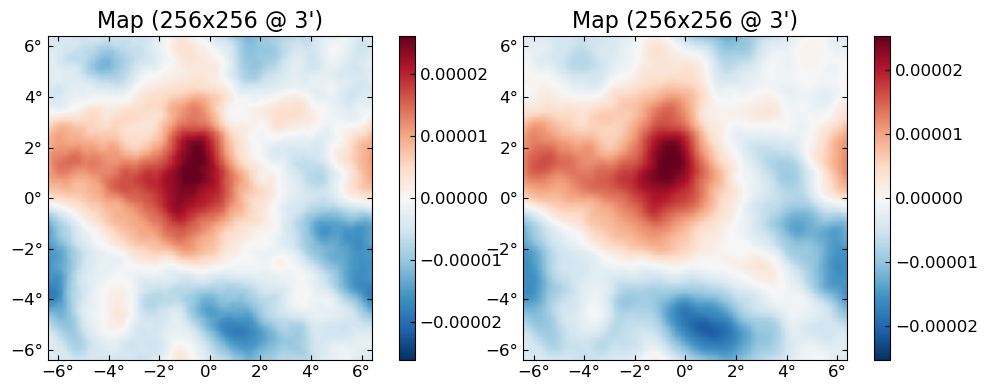

In [26]:
plot([ϕ ϕJ])

## Batching

Just moving a `DataSet` to GPU will give you factors of about 2 - 10 speeds over CPU for `Nside` of 128 - 1024. You can go even faster by "batching," which means doing the same operations to multiple fields at once, i.e. in "batches". The trick is that for the full speedup, this parallelization has to happen on the inner-most-loop so that the GPU basically goes through the data all at once with a single GPU kernel. 

Suppose you had 10 fields on GPU that you want to lense:

In [17]:
fs = [simulate(ds.Cf) for i=1:10]
ϕs = [simulate(ds.Cϕ) for i=1:10];

You could do the following, and it might still be a little faster than doing it sequentially:

In [18]:
f̃s = [LenseFlow(ϕ)*f for (f,ϕ) in zip(fs,ϕs)];

But the really fast way to do it is pack those 10 fields into a "batched" field (note the indication these are batched in the printed type information:

In [19]:
f_batch = batch(fs)

65536(×10)-element FlatEBFourier{256×256(×10) map, 3′ pixels, fourier∂, CuArray{Complex{Float32},3,Nothing}}:
         0.0f0 + 0.0f0im
   2067.3645f0 + 399.77438f0im
  -2287.3489f0 + 61.209045f0im
  -1842.4508f0 - 1402.0479f0im
  -179.26314f0 + 5688.655f0im
  -2507.1204f0 - 6289.249f0im
   -2534.921f0 - 2604.5217f0im
   1377.6554f0 + 2449.9495f0im
  -1669.2716f0 + 4222.159f0im
  -5429.2827f0 - 3590.9233f0im
   3358.9407f0 + 3246.1667f0im
   392.65005f0 - 934.55023f0im
  -1447.2839f0 + 5346.973f0im
               ⋮
  0.47957772f0 - 0.02278672f0im
 0.023363959f0 - 0.22786018f0im
  -0.3964136f0 - 0.09403831f0im
  0.10330974f0 - 0.028876595f0im
 -0.03227594f0 + 0.21710716f0im
  0.16192076f0 - 0.04576766f0im
  0.10407528f0 + 0.07237351f0im
  0.05083293f0 - 0.35345325f0im
 0.101648785f0 - 0.12514368f0im
 -0.04007726f0 - 0.06135367f0im
 -0.07751867f0 - 0.67276037f0im
 -0.07812396f0 + 0.14952393f0im

In [20]:
ϕ_batch = batch(ϕs)

65536(×10)-element FlatFourier{256×256(×10) map, 3′ pixels, fourier∂, CuArray{Complex{Float32},3,Nothing}}:
          -0.0f0 + 0.0f0im
   -0.07079744f0 + 0.18514323f0im
    0.03290303f0 + 0.0133099845f0im
   0.055003528f0 - 0.010883388f0im
   0.013071878f0 - 0.013901264f0im
  0.0026314836f0 + 0.009495603f0im
   -0.01535961f0 - 0.0039537353f0im
 -0.0028406451f0 + 0.008155016f0im
  -0.001929042f0 - 0.0010767351f0im
 -0.0024420973f0 - 0.0018367962f0im
 -0.0011192076f0 + 0.002002884f0im
 0.00020532266f0 - 0.0008051438f0im
     8.774912f-5 + 0.00035183338f0im
                 ⋮
   -9.2856413f-7 - 1.313165f-6im
    2.0182463f-7 + 3.746073f-7im
   -5.4367683f-7 - 1.739188f-7im
    1.3828416f-7 - 5.1108645f-7im
    1.4031918f-6 - 1.4046443f-6im
    -1.070646f-6 - 4.3022308f-7im
   -8.3058893f-7 + 4.4700573f-7im
   -1.1472754f-6 + 1.0367636f-6im
    2.5662965f-7 + 1.7411496f-7im
    1.9959869f-7 - 1.2536533f-6im
    -2.902696f-7 - 1.3798117f-7im
     4.514513f-7 - 8.350644f-7im

And then lense once:

In [21]:
f̃_batch = LenseFlow(ϕ_batch) * f_batch

65536(×10)-element FlatQUMap{256×256(×10) map, 3′ pixels, fourier∂, CuArray{Float32,3,Nothing}}:
  2.1484423
  0.76446104
 -4.805173
 -5.590993
 -1.6229104
 -2.71861
 -4.7061634
 -2.4944959
  0.28382298
  1.0812734
 -3.2973764
 -4.6749506
 -3.0414338
  ⋮
  2.4021819
  6.0399837
  6.6011925
  5.1880527
  3.5844803
  0.2498419
 -5.5041223
 -8.682015
 -6.0994425
 -0.7920846
 -0.6332435
 -2.956285

For the problem size of `Nside=256`, doing this batch of 10 lenses is almost no slower than doing a single one. 

You can get the individual fields out of the batched result with `batchindex`, e.g. the first 2 of 10:

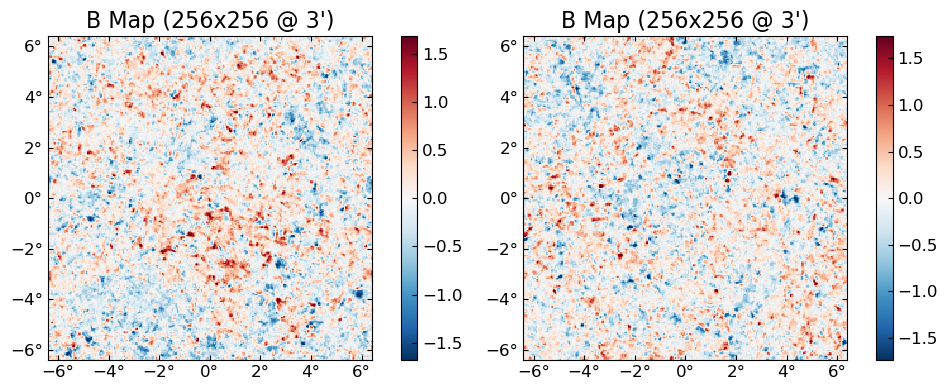

In [27]:
plot([batchindex(f̃_batch,1) batchindex(f̃_batch, 2)], which=:Bx)

Most of CMBLensing works with batched fields just like with normal fields. This includes things like `lnP`, `conjugate_gradient` or `sample_joint`, although `MAP_joint` and `MAP_marg` only work with non-batched fields (but will be fixed in the future).

## Gotchas

Not much, hopefully. If something that works on CPU doesn't work on GPU, please file an Issue.

One thing to keep in mind is that CPU and GPU use different random number generators, so seeds will not correspond.

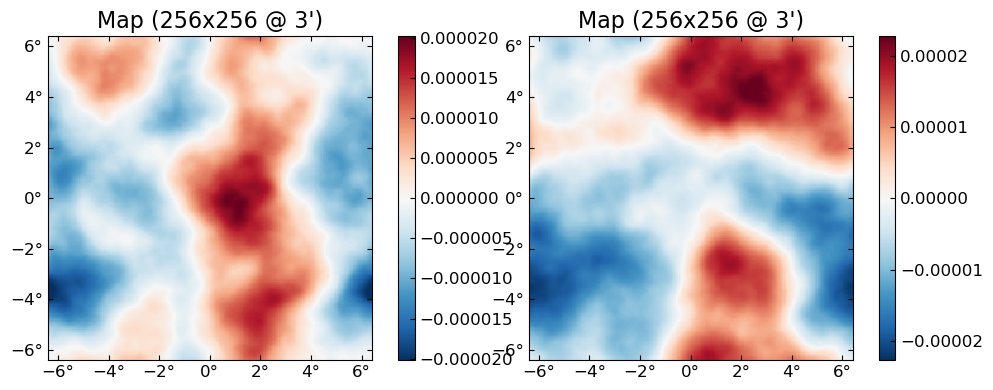

In [30]:
plot([simulate(cpu(ds.Cϕ), seed=0) simulate( cu(ds.Cϕ), seed=0)])